# INTERPRETING SYSTEM IDENTIFICATION RESULTS

System identification produces a transfer function that approximates how the measured output changes with changes in the control input.
This notebook shows that the transfer function can be interpreted as a reaction network.
This means that we can think of system identification as a way to create a very simple ("low order")
reaction network that approximates our original open loop system.

## Preliminaries

In [1]:
import numpy as np
try:
    import controlSBML as ctl
except:
    !pip install -q controlSBML
    import controlSBML as ctl

import matplotlib.pyplot as plt
import control
import numpy as np
import pandas as pd
try:
    import tellurium as te
except:
    !pip install -q controlSBML
    import tellurium as te
ctl.__version__

'1.2.4'

In [2]:
s = control.TransferFunction.s

# Helpers

In [3]:
k1=1; k2=2; k3=3;
TEST_MODEL = f"""
$S1 -> S2; k1*S1
S2 -> 3 S2 + S3; k2*S2
S3 -> ; k3*S3

S1 = 1
S2 = 0
S3 = 0
k1 = {k1}
k2 = {k2}
k3 = {k3}
"""
# Construct the transfer function for G(s) at k1=1
TEST_TF = control.TransferFunction([k2*k1], [1, k3 - 2*k2, -2*k2*k3])
#

In [4]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax

    def __repr__(self):
        return ""

## plotTransferFunction

In [5]:
def plotTransferFunction(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTransferFunction(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


## evaluateTransferFunction

In [6]:
def evaluateTransferFunction(antimony_model:str, transfer_function:control.TransferFunction,
        title:str="", is_plot:bool=True):
    # Plot the simulation results against the transfer function predictions
    # Assumes that the forced input is 1 and that the output is the last species in the simulation model
    rr = te.loada(antimony_model)
    data = rr.simulate(0, 10, 100)
    output_name = data.colnames[-1]
    times = data["time"]
    _, yt = control.step_response(transfer_function, T=times)
    ymax = np.max(data[output_name])
    plt.scatter(data[output_name], yt)
    plt.plot([0, ymax], [0, ymax], color="red", linestyle="--")
    plt.xlabel("actual")
    plt.ylabel("predicted")
    if len(title) == 0:
        title = output_name[1:-1]
    plt.title(title)
    if not is_plot:
        plt.close()
        
# TESTS
evaluateTransferFunction(TEST_MODEL, TEST_TF, is_plot=False)
print("OK!")

OK!


# Interpreting the Laplace Transform as a Reaction Network

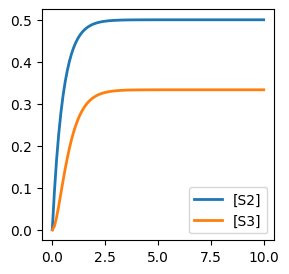

In [7]:
k1 = 1.0
k2 = 2.0
k3 = 3.0
SEQUENTIAL_MODEL = f"""
model *model_main()
J1: $S1 -> S2; k1*S1
J2: S2 -> S3; k2*S2
J3: S3 -> ; k3*S3
S1 = 1; S2 = 0; S3 = 0

k1 = {k1}
k2 = {k2}
k3 = {k3}
end
"""
rr = te.loada(SEQUENTIAL_MODEL)
rr.simulate(0, 10, 100)
rr.plot(figsize=(3,3))

The exact solution for this system is
$$G = \frac{{S}_3 (s)}{S_1 (s)} = \frac{k_1 k_2}{(s + k_2)(s + k_3)}$$

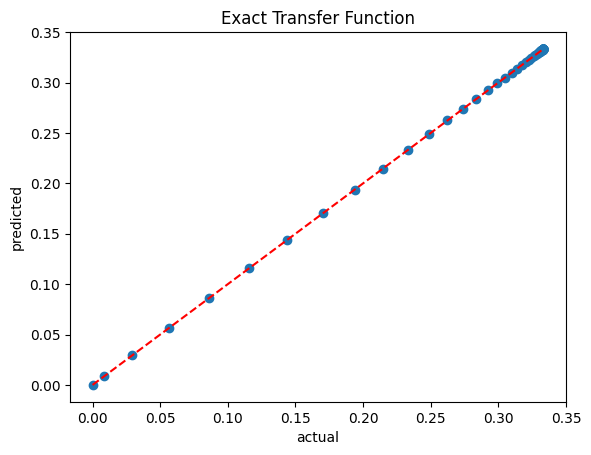

In [9]:
evaluateTransferFunction(SEQUENTIAL_MODEL, G_tru, title="Exact Transfer Function")

In [10]:
G_tru.zeros(), G_tru.poles()

(array([], dtype=complex128), array([-3.+0.j, -2.+0.j]))

## No zeros, 1 pole

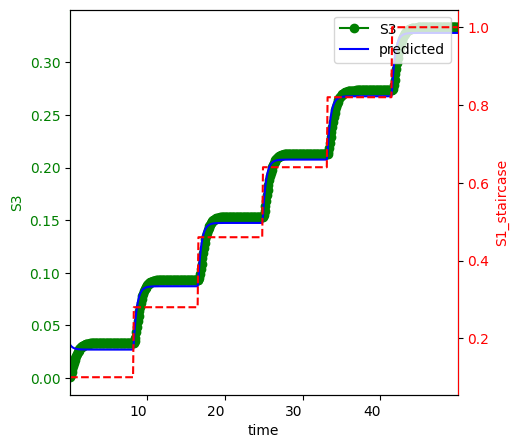

In [14]:
SEQUENTIAL_CTLSB = ctl.ControlSBML(SEQUENTIAL_MODEL, input_name="S1", output_name="S3")
result = SEQUENTIAL_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=1,
            initial_value=0.1, final_value=1,
            times=np.linspace(0, 50, 500))

In [15]:
SEQUENTIAL_CTLSB.getOpenLoopTransferFunction()

TransferFunction(array([29838.72389145]), array([36146.00746981, 89273.29559003]))

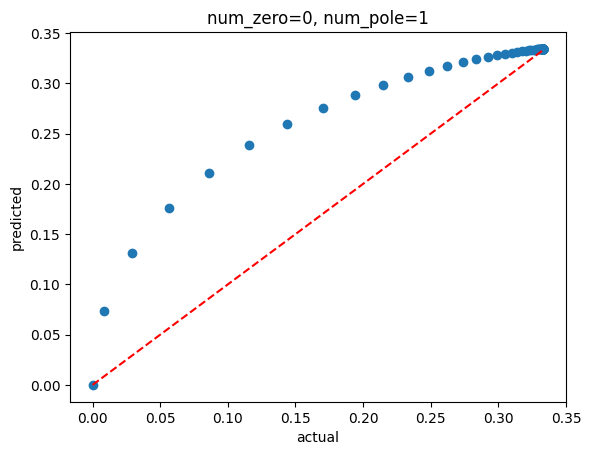

In [16]:
# Comparison of unit step response of the true model and the no-zero/1-pole transfer function
evaluateTransferFunction(SEQUENTIAL_MODEL,
            SEQUENTIAL_CTLSB.getOpenLoopTransferFunction(), title="num_zero=0, num_pole=1")

## No zeros, 2 poles

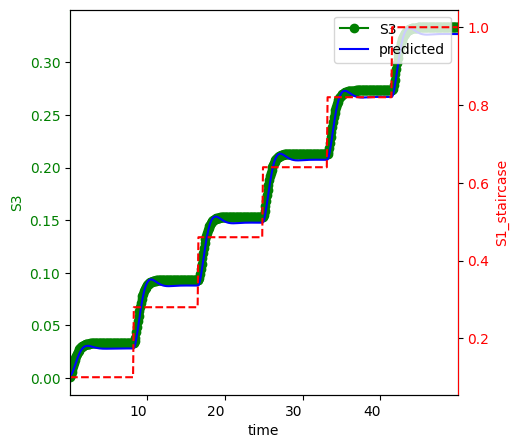

In [11]:
SEQUENTIAL_CTLSB = ctl.ControlSBML(SEQUENTIAL_MODEL, input_name="S1", output_name="S3")
result = SEQUENTIAL_CTLSB.plotTransferFunctionFit(num_zero=0, num_pole=2,
            initial_value=0.1, final_value=1,
            times=np.linspace(0, 50, 500))

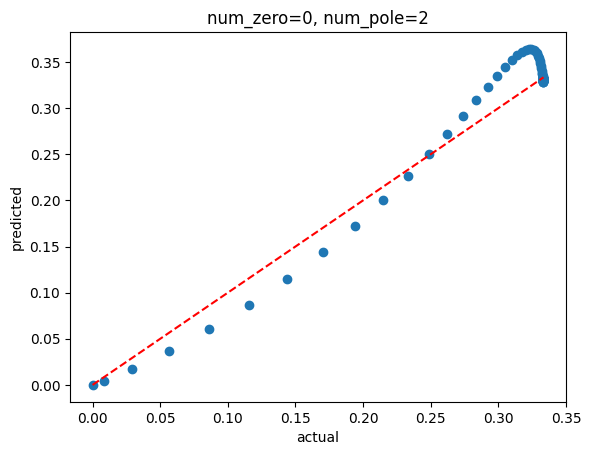

In [12]:
evaluateTransferFunction(SEQUENTIAL_MODEL,
            SEQUENTIAL_CTLSB.getOpenLoopTransferFunction(), "num_zero=0, num_pole=2")

In [13]:
SEQUENTIAL_CTLSB.getOpenLoopTransferFunction().poles()

array([-1.02905612+1.38864596j, -1.02905612-1.38864596j])

# Reverse Engineering the Reaction Network

**Problem Statement**
* Given the transfer function $G(s)$
* Find a reaction network whose exact transfer function is $G(s)$

## No zero, 1 pole

$${\Large G(s) = \frac{k_1}{s + k_2}}$$

${\Large
\begin{eqnarray}
J1: S_1 & \xrightarrow{k_1 S_1} & S_2 \\
J2: S_2 & \xrightarrow{k_2 S_2} & \emptyset
\end{eqnarray}
}$

A **path** is a sequence of reactions that results in converting the input species to the output species.

Example: $J1$

Let ${\bf P}$ be a path from input species to output species.

**Intuition for Mass Action Kinetics**
* The numerator is the product of kinetic constants ${\bf P}$.
* The denominator is the product of terms $(s + k)$, where $k$ is the kinetic constant for the degradation of the output species or a species in ${\bf P}$ (excluding the input species).

## No zero, 2 pole

$${\Large G(s) = \frac{k_1 k_2}{(s + k_2)(s + k_3)}}$$

${\Large
\begin{eqnarray}
J1: S_1 & \xrightarrow{k_1 S_1} & S_2 \\
J2: S_2 & \xrightarrow{k_2 S_2} & S_3 \\
J3: S_3 & \xrightarrow{k_3 S_2} & \emptyset
\end{eqnarray}
}$

The **path** is a sequence of reactions that results in converting the input species to the output species.

Example: $J1,~ J2$

Let ${\bf P}$ be a path from input species to output species.

**Application to example**
* The numerator is the product of kinetic constants ${\bf P}$: $k_1 k_2$
* The denominator is the product of terms $(s + k)$, where $k$ is the kinetic constant for the degradation of the output species or a species in ${\bf P}$ (excluding the input species): $(s + k_2) (s + k_3)$.

## 1 zero, 3 poles

${\Large
\begin{eqnarray}
G(s) & = & \frac{As + B}{(s + k_2)(s + k_4) (s + k_5)} \\
A & =&  k_1 k_2 + k_3 k_4 \\
B & = & k_2 k_4 (k_1 + k_3)
\end{eqnarray}
}$


This is the transfer function for the chemical system below.

${\Large
\begin{eqnarray}
J1: S_1 & \xrightarrow{k_1 S_1} & S_2 \\
J2: S_2 & \xrightarrow{k_2 S_2} & S_5 \\
J3: S_1 & \xrightarrow{k_3 S_1} & S_4 \\
J4: S_4 & \xrightarrow{k_4 S_4} & S_5 \\
J5: S_5 & \xrightarrow{k_5 S_5} & \emptyset
\end{eqnarray}
}$

We see the species degradation in the denominator.

The numerator is more complicated

It makes a bit more sense if we expand the fraction

\begin{eqnarray}
G(s) & = & \frac{k_1 k_2}{(k_5 - k_2)(s + k_2)} + \frac{k_3 k_4}{(k_5 - k_4)(s + k_4)} - \left(\frac{k_1 k_2}{k_5 - k_2} + \frac{k_3 k_4}{k_5 - k_4}\right)\frac{1}{s + k_5}
\end{eqnarray}

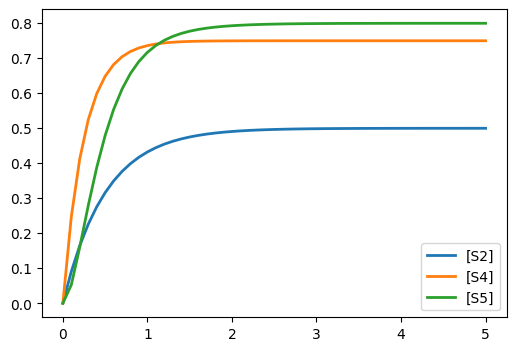

In [17]:
k1=1; k2=2; k3=3; k4=4; k5=5
MODEL3 = f"""
J1: S1 -> S2; k1*S1
J3: S1 -> S4; k3*S1
J2: S2 -> S5; k2*S2
J4: S4 -> S5; k4*S4
J5: S5 -> ; k5*S5
k1={k1}
k2={k2}
k3={k3}
k4={k4}
k5={k5}
$S1 = 1
"""
rr = te.loada(MODEL3)
rr.simulate()
rr.plot()

In [18]:
numerator = [k1*k2 + k3*k4, k2*k4*(k1 + k3)]
denominator = [1, k2 + k4 + k5, k2*k4 + k2*k5 + k4*k5, k2*k4*k5]
G_tf = control.TransferFunction(numerator, denominator)
G_tf

TransferFunction(array([14, 32]), array([ 1, 11, 38, 40]))

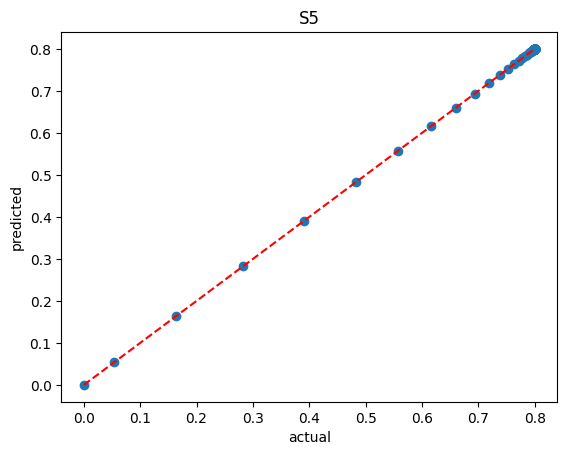

In [19]:
evaluateTransferFunction(MODEL3, G_tf)